In [ ]:
#imports
import math
#PyTorch imports
import torch
import torch.nn as nn
from torch.optim import AdamW
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Import SciPy to load the Flowers-102 dataset from the .mat format
import scipy.io

#Other imports
import numpy as np
import matplotlib.pyplot as plt

#Import time so that we can train the model within the 12 hour time limit
import time

In [ ]:
#Define transforms
trainingTransform = transforms.Compose([
    transforms.Resize(224), #Change this value to edit the image size
    transforms.CenterCrop(224), #Must be the same as resize value. This is used to ensure the image is square
    #Default probability for both flips is p=0.5, can be changed if needed
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #Rotates each image by a random angle between 0-90 degrees
    transforms.RandomRotation(90),
    #TODO: Find out how to apply this transformation randomly
    # (note from Olivia, use the range! satruation can go High but
    # then the images look weird, hsue has to be between -0.5-0.5)
    #transforms.ColorJitter(saturation=[0, 5], hue=(-0.5, 0.5)),
    transforms.ToTensor(),
    transforms.Normalize(0,1) #zerocenter normalization
])

nonTrainTransform = transforms.Compose([
    #Same as training transform without flipping as required
    #by assessment rules
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

#Load Flowers-102 dataset and split it into train, validate and test splits
trainingSet = datasets.Flowers102(root="./flowers", split="train", download=True, transform=trainingTransform)
validationSet = datasets.Flowers102(root="./flowers", split="val", download=True, transform=nonTrainTransform)
testingSet = datasets.Flowers102(root="./flowers", split="test", download=True, transform=nonTrainTransform)

In [ ]:
#Checking the splits are the correct length
print(len(trainingSet))
print(len(validationSet))
print(len(testingSet))

1020
1020
6149


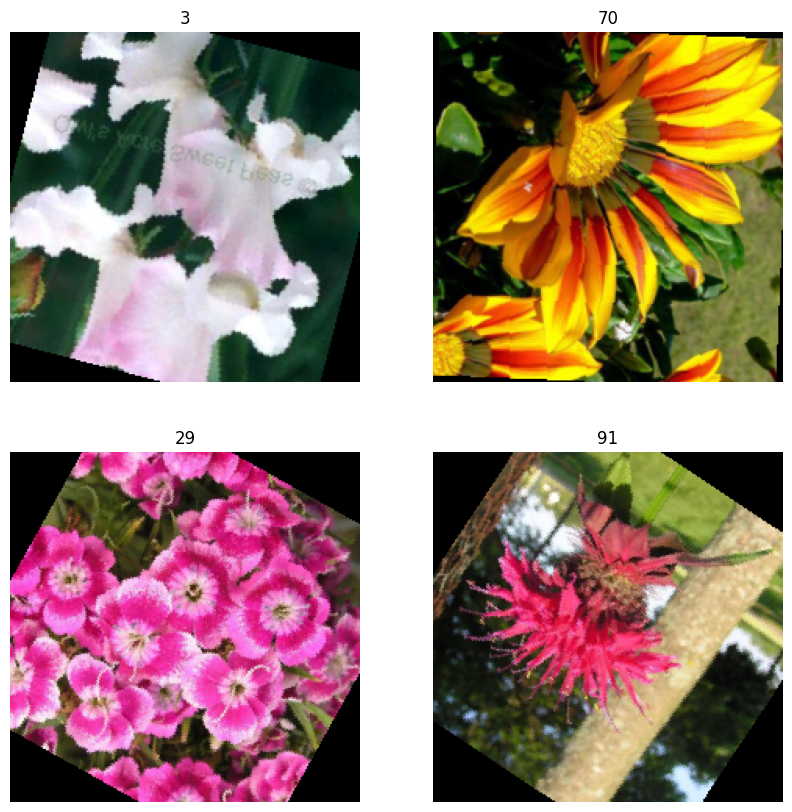

In [ ]:
#Checking the training transformations are ok
figure = plt.figure(figsize=(10,10))
col, row = 2, 2
for i in range(1, 5): #TODO: Change this to be rows * columns
  randImg = torch.randint(len(trainingSet), size=(1,)).item() #Size defines the shape of the tensor
  img, label = trainingSet[randImg]
  figure.add_subplot(row, col, i)
  plt.title(label)
  plt.axis(False)
  plt.imshow(img.squeeze().permute(1,2,0)) #Permute gets the dimentions in the correct order
plt.show()

In [ ]:
#Checking if collab can connect to a GPU
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')


In [ ]:
#The CNN itself
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    #DEFINING THE LAYERS. THIS IS WHERE WE WILL SPEND MOST OF OUR TIME
    self.netLayers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=(1,1), padding=1),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=(1,1), padding=1),
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=(1,1), padding=1),
        nn.AvgPool2d(2,2),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=(1,1), padding=1),
        nn.BatchNorm2d(256),
        #nn.LeakyReLU(), #LeakyReLU is used to prevent 'dead ReLU' issues
        nn.ReLU(),
        nn.Dropout(0.15),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=(1,1), padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=(1,1), padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Flatten(),
        #IMPORTANT: in channels for first linear must be
        # (image size) * (image size) * C
        #Where C is the out channels of the last conv2d
        #If confused, just print out the shape of the matrix
        nn.Linear(100352, 128),
        nn.BatchNorm1d(128),
        nn.Linear(128, 64),
        nn.Dropout(0.05),
        nn.Linear(64, 102), #102 for the classifiers
        nn.LogSoftmax(dim=1)
    )
  
  def forward(self, x):
      result = self.netLayers(x)
      #print(result.shape)
      return result
  


In [ ]:
#TODO: Code to train the CNN on the training set for a set amount of minutes.
def timedTrain(minutes, cnn, lossFunction, optimiser, showGraph):
  startTime = time.time()
  endTime = time.time() + (minutes * 60)
  trainingError = []


In [ ]:
#Code to train the CNN based on a set number of epochs
def epochCountTrain(trainLoader, cnn, optimizer, lossFunction):
  totalLoss, correct = 0, 0
  size = len(trainLoader.dataset)
  for i, data in enumerate(trainLoader, 0):
    input, labels = data
    input = input.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = cnn(input)
    loss = lossFunction(output, labels)
    loss.backward()
    optimizer.step()
    totalLoss += loss.item()
    correct += (output.argmax(1)==labels).sum().item()
    if i % 20 == 0:
      loss, currentLoss = loss.item(), (i + 1) * len(input)
      print(f"loss: {loss:>7f}    [{currentLoss:>5d}/{size:>5d}]")
  print(f"\n Avg train loss: {(totalLoss/len(trainLoader)):>8f}")
  print(f"Test accuarcy = {((correct/1020) * 100): >0.1f}%")

In [ ]:
#Code to guess accuracy based on validation set
def validation(valLoader, cnn, lossFunction):
  valSize = len(valLoader.dataset)
  correct = 0
  loss = []
  with torch.no_grad(): #as we are not calling backward, use no grad to save memory
    for batch in valLoader:
      input, labels = batch
      input = input.to(device)
      labels = labels.to(device)
      prediciton = cnn(input)
      loss.append(lossFunction(prediciton, labels).item())
      correct += (prediciton.argmax(1) == labels).sum().item()
  
  print(f"Accuracy on validation set = {((correct / valSize) * 100):>0.1f}%")
  print(f"Average loss on validation set = {(np.average(loss))}")




In [ ]:
#Actual code to get it all running
epochCount = 100
learningRate = 0.00005
batchSize = 32
lossFunction = nn.CrossEntropyLoss()
model = CNN().to(device)
optimizer = AdamW(lr=learningRate, params=model.parameters(), weight_decay=0.1)
trainDataloader = DataLoader(trainingSet, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(validationSet, batch_size=batchSize, shuffle=True)
for i in range(epochCount):
  print(f"Epoch {i}")
  model.train()
  epochCountTrain(trainDataloader, model, optimizer, lossFunction)
  model.eval()
  validation(valDataloader, model, lossFunction)

Epoch 0
loss: 4.655429    [   32/ 1020]
loss: 4.335301    [  672/ 1020]

 Avg train loss: 4.365114
Test accuarcy = 5.0%
Accuracy on validation set = 0.4%
Average loss on validation set = 4.747262433171272
Epoch 1
loss: 4.068168    [   32/ 1020]
loss: 4.086374    [  672/ 1020]

 Avg train loss: 4.041153
Test accuarcy = 12.8%
Accuracy on validation set = 6.3%
Average loss on validation set = 4.305516615509987
Epoch 2
loss: 3.737636    [   32/ 1020]
loss: 3.975258    [  672/ 1020]

 Avg train loss: 3.875981
Test accuarcy = 16.3%
Accuracy on validation set = 11.3%
Average loss on validation set = 4.0662055388092995
Epoch 3
loss: 3.554561    [   32/ 1020]
loss: 3.881721    [  672/ 1020]

 Avg train loss: 3.754065
Test accuarcy = 20.2%
Accuracy on validation set = 13.9%
Average loss on validation set = 3.991108812391758
Epoch 4
loss: 3.533789    [   32/ 1020]
loss: 3.804242    [  672/ 1020]

 Avg train loss: 3.658689
Test accuarcy = 24.5%
Accuracy on validation set = 16.8%
Average loss on va